In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
pd.set_option("display.max_colwidth",200)
pd.options.display.float_format = '{:,.2f}'.format

# 1. Movies dataset

## 1. Mô tả dữ liệu: Dữ liệu mô tả các bộ phim nổi tiếng nhất từ 2003-2022
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu mô tả các thông tin về bộ phim như: thể loại, đạo diện sản xuất, dàn diễn viên, thời gian khởi chiếu, v.v </span>
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu cũng cho biết các thông tin về doanh thu như: số vốn đầu tư và doanh thu</span>
- <span style="font-size:18px;font-family: Times New Roman;">Ý nghĩa các trường thuộc tính trong dataset:</span>
    | Syntax      | Description |
    | ----------- | ----------- |
    | Title      | Tên phim       |
    | Rating   | điểm đánh giá phim dựa theo iMDB        |
    | Year      | Năm khởi chiếu       |
    | Month   | Tháng khởi chiếu        |
    | Certificate      | Chứng chỉ film       |
    | Runtime   | Thời lượng phim        |
    | Directors      | Đạo diễn       |
    | Stars   | Diễn viên trong film        |
    | Genre      | Thể loại       |
    | Filming_location   | Địa điểm phim quay hình        |
    | Country_of_origin   | Quốc gia tham gia sản xuất        |

**<span style="font-size:17px;">Dữ liệu được update lần cuối trên kaggle là 02/03/2023.</span>**

## 2. Bài toán
- <span style="font-size:18px;font-family: Times New Roman;">Tập dữ liệu có thể giúp xây dựng **recommendation system** để giới thiệu end-user các bộ phim đang hot hiện nay </span>
- <span style="font-size:18px;font-family: Times New Roman;">Từ đó giúp cải thiện doanh số cho các công ty kinh doanh về mảng chiếu phim.</span>

## 3. EDA

In [3]:
movie_df = pd.read_csv('movies.csv')
movie_df.head(2)

,Title,Rating,Year,Month,Certificate,Runtime,Directors,Stars,Genre,Filming_location,Budget,Income,Country_of_origin
0,Avatar: The Way of Water,8.00,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver, Stephen Lang","Action, Adventure, Fantasy",New Zealand,"$350,000,000","$681,081,686",United States
1,Guillermo del Toro's Pinocchio,7.80,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Burn Gorman","Animation, Drama, Family",USA,"$35,000,000","$71,614","United States, Mexico, France"


### 3.1 Dữ liệu có bao nhiêu dòng, cột

In [4]:
print(f'Dữ liệu có {movie_df.shape[0]} dòng')
print(f'Dữ liệu có {movie_df.shape[1]} cột')

Dữ liệu có 2000 dòng
Dữ liệu có 13 cột


### 3.2 Dữ liệu có thị trùng lặp hay không ?

In [5]:
movie_df.duplicated().sum()

0

### 3.3 Kiểu dữ liệu có gì bất thường ?

In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              2000 non-null   object 
 1   Rating             1998 non-null   float64
 2   Year               2000 non-null   int64  
 3   Month              2000 non-null   object 
 4   Certificate        1966 non-null   object 
 5   Runtime            2000 non-null   object 
 6   Directors          2000 non-null   object 
 7   Stars              2000 non-null   object 
 8   Genre              2000 non-null   object 
 9   Filming_location   2000 non-null   object 
 10  Budget             2000 non-null   object 
 11  Income             2000 non-null   object 
 12  Country_of_origin  2000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 203.2+ KB


<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dữ liệu chưa giá trị Unknown tương đương NaN </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dữ liệu numerical bao gồm các trường thuộc tính rating, year. Còn lại đa số là kiểu object hoặc categorical </span>
- <span style="font-size:17px;font-family: Times New Roman;">Một số trường thuộc tính như budget, income có sai khác về đơn vị đo lường. </span>

<span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý giá trị Unknown** </span> 

In [7]:
movie_df.replace('Unknown', np.nan, inplace=True)

<span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý trường thuộc tính Budget và Income** </span> 

In [8]:
# các giá trị tiền tệ
movie_df['Budget'].str[:1].value_counts()

$    1619
€      39
£      20
₩       4
C       3
₹       2
¥       2
A       2
S       1
D       1
N       1
Name: Budget, dtype: int64

In [9]:
# hệ quy đổi tiền tệ, chúng ta lấy $(USD) là chuẩn.
conversion_dict = {
    '$': 1.0,
    '€': 1.07,
    '£': 1.21,
    '₩': 0.00078,
    'C': 0.73,
    '₹': 0.012,
    '¥': 0.0075,
    'A': 0.68,
    'S': 0.095,
    'D': 0.14,
    'N': 0.10 
}

for idx in range(movie_df.shape[0]):
    if not pd.isnull(movie_df.loc[idx,'Budget']):
        movie_df.loc[idx,'Budget'] = int(re.sub("[^0-9]", "",movie_df.loc[idx,'Budget'])) * conversion_dict[movie_df.loc[idx,'Budget'][:1]]
    
    if not pd.isnull(movie_df.loc[idx,'Income']):
        movie_df.loc[idx,'Income'] = int(re.sub("[^0-9]", "",movie_df.loc[idx,'Income'])) * conversion_dict[movie_df.loc[idx,'Income'][:1]]
        
        
# chuyển đổi dữ liệu cột Budget và Income, Runtime vê float
movie_df['Budget'] = movie_df['Budget'].astype('float64')
movie_df['Income'] = movie_df['Income'].astype('float64')
movie_df['Runtime'] = movie_df['Runtime'].astype('float64')

### 3.4 Mỗi trường thuộc tính có giá trị thiếu không ?

In [10]:
movie_df.isna().sum()

Title                  0
Rating                 2
Year                   0
Month                  0
Certificate           34
Runtime                2
Directors              0
Stars                  0
Genre                  0
Filming_location      76
Budget               306
Income               146
Country_of_origin      0
dtype: int64

### 3.5 Thống kê dữ liệu numerical

In [11]:
def missing_ratio(column):
    return (column.isna().mean() * 100).round(2)

def lower_quantile(column):
    return column.quantile(q= 0.25)

def upper_quantile(column):
    return column.quantile(q= 0.75)


In [25]:
numerical_df = movie_df[['Rating', 'Runtime', 'Budget', 'Income']]
numerical_df.aggregate([missing_ratio, pd.Series.min, lower_quantile,
                          pd.Series.mean, upper_quantile, pd.Series.max])

,Rating,Runtime,Budget,Income
missing_ratio,0.10,0.05,15.32,7.26
min,1.90,50.00,10.00,305.00
lower_quantile,6.20,99.00,"17,000,000.00","24,598,259.00"
mean,6.67,113.22,"61,297,739.64","187,926,334.08"
upper_quantile,7.30,124.00,"85,000,000.00","220,673,217.00"
max,9.60,242.00,"356,000,000.00","2,922,917,914.00"


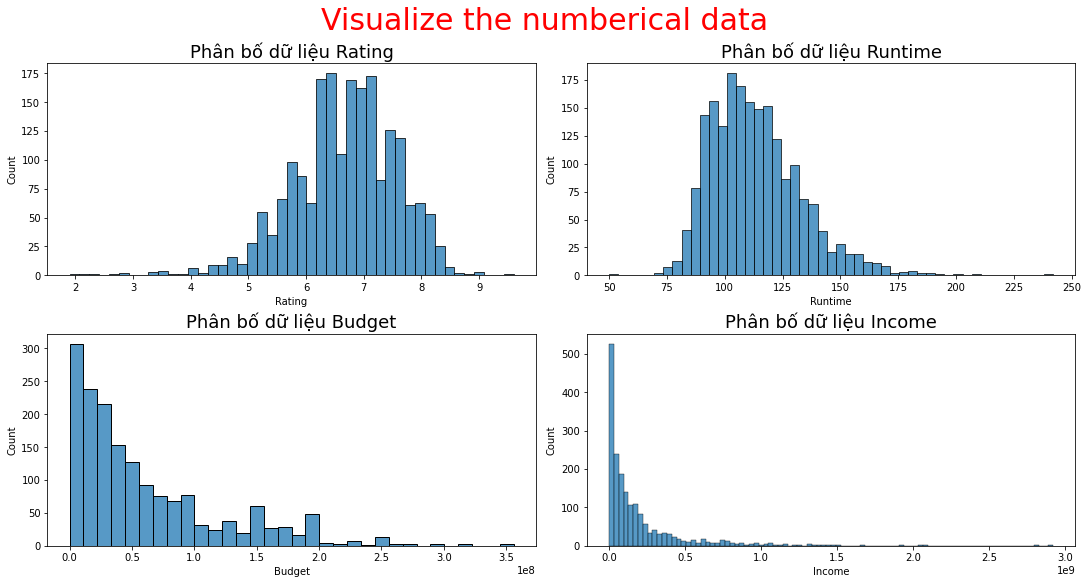

In [34]:
plt.rcParams['figure.figsize'] = 15,8
fig , axs = plt.subplots(2,2,constrained_layout = True)
idx = 0
while idx < numerical_df.shape[1]:
    r , c = idx // 2, idx % 2
    sns.histplot(x = numerical_df.iloc[:,idx], ax = axs[r,c])
    axs[r,c].set_title(f'Phân bố dữ liệu {numerical_df.columns[idx]}', fontsize = 18)
    idx += 1

plt.suptitle('Visualize the numberical data', fontsize = 30, color = 'red')
plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các trường thuộc tính **Rating và Runtime** gần với phân phối chuẩn. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các trường thuộc tính **Budget và Income** thì bị lệch trái khá nhiều. </span>

### 3.6 Thống kê dữ liệu categorical

In [14]:
movie_df[['Month', 'Certificate', 'Filming_location']].agg([missing_ratio,pd.Series.unique,pd.Series.nunique])

,Month,Certificate,Filming_location
missing_ratio,0.00,1.70,3.80
unique,"[December, August, November, January, October, March, September, May, April, July, June, February, 2014, 2008]","[PG-13, PG, R, TV-14, TV-MA, TV-PG, TV-Y7, Not Rated, nan, NC-17, TV-G, Unrated, G]","[New Zealand, USA, Japan, Ireland, nan, Canada, UK, Norway, Greece, Mexico, Spain, Italy, Bulgaria, Australia, Iceland, Belgium, Germany, Turkey, South Africa, France, South Korea, India, Egypt, A..."
nunique,14,12,96


<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trường thuộc tính Month có các giá trị sai như 2014, 2008 $\rightarrow$ Xóa những dòng này</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các trường thuộc tính **genre, directs, stars, country_of_origin** có thể là danh sách nhưng vẫn chưa được tiền xử lý </span>

In [15]:
movie_df = movie_df[(movie_df['Month'] != '2014')\
                    &(movie_df['Month'] != '2008')].reset_index().drop(columns = 'index')

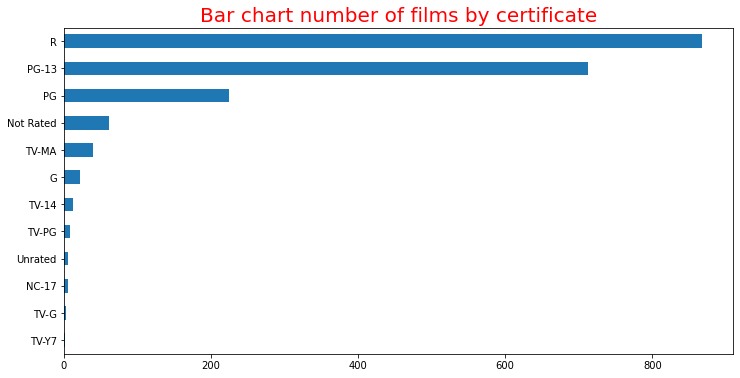

In [36]:
plt.rcParams['figure.figsize'] = 12,6
movie_df['Certificate'].value_counts(ascending=True).plot.barh()
plt.title('Bar chart number of films by certificate', fontsize=20 ,color='red');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số các phim có chứng chỉ thuộc về R (trên 17 tuổi) và PG-13 (trên 13 tuổi) với số lượng áp đảo. Tiếp theo sau là PG và Not Rated. </span>

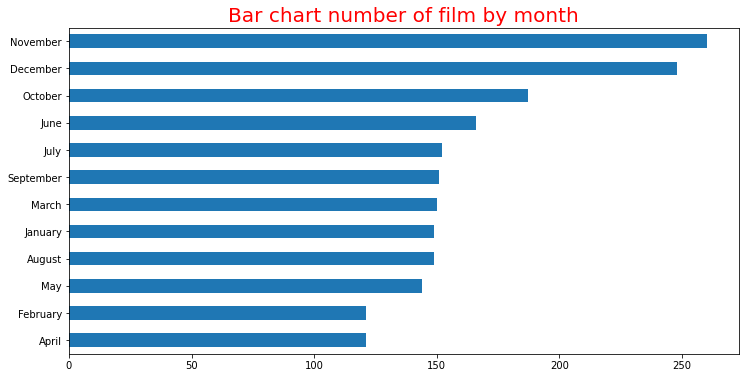

In [40]:
movie_df['Month'].value_counts(ascending=True).plot.barh()
plt.title('Bar chart number of film by month', fontsize=20 ,color='red');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số các phim có phát hành vào khoảng thời gian cuối năm từ tháng 10 đến tháng 12. Các tháng còn lại thì chênh lệch không đáng kể với nhau </span>

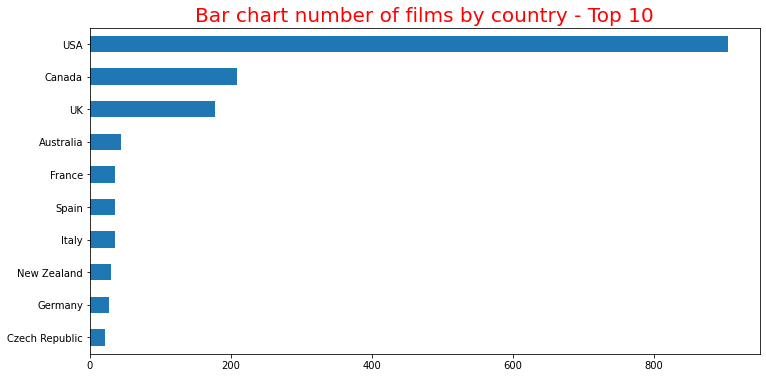

In [38]:
movie_df['Filming_location'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by country - Top 10', fontsize=20 ,color='red');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Đa số các phim phổ biến ở được quay hình ở USA với số lượng áp đảo. Tiếp theo sau là các nước Canada và UK cũng khá nhiều bộ phim nổi bật hơn so với các quốc gia còn lại.</span>

<span style="font-size:18px;font-family: Times New Roman;">**Tiền xử lý trường thuộc Genre, Directors, Stars, Country_of_origin** </span>  

In [19]:
movie_df['Genre'] = movie_df['Genre'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Directors'] = movie_df['Directors'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Stars'] = movie_df['Stars'].apply(lambda x: [i.strip() for i in x.split(',')])
movie_df['Country_of_origin'] = movie_df['Country_of_origin'].apply(lambda x: [i.strip() for i in x.split(',')])

<span style="font-size:18px;font-family: Times New Roman;">**Thống kê dữ liệu trường thuộc Genre, Directors, Stars, Country_of_origin** </span> 

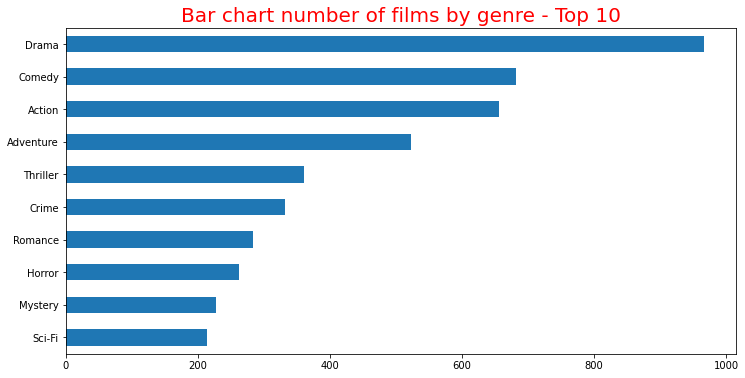

In [20]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Genre')['Genre'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by genre - Top 10', fontsize=20 ,color='red');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 thể loại phim thì phổ biến nhất là **Drama**, các thể loại phim như **Comedy, Action, Adventure** cũng chiếm số lượng lớn. </span>
- <span style="font-size:17px;font-family: Times New Roman;">Các thể loại còn lại trong danh sách cũng chiếm số lượng tương đối và không chênh lệch nhau đáng kể </span>

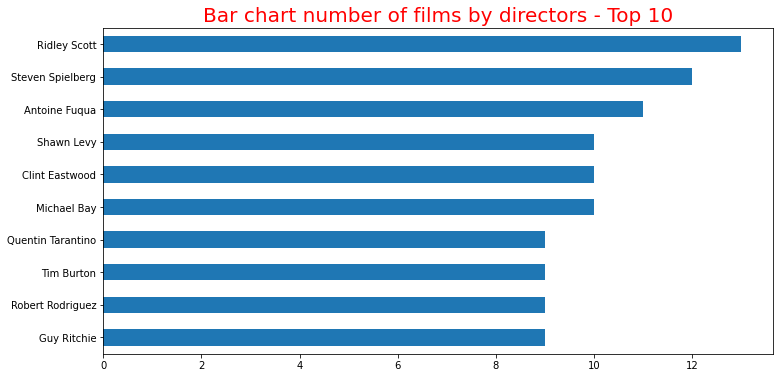

In [51]:
movie_df.explode('Directors')['Directors'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by directors - Top 10', fontsize=20 ,color='red');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 đạo diễn có số lượng phim cao nhất thì nổi bật hơn là đạo diễn **Ridley Scott** </span>

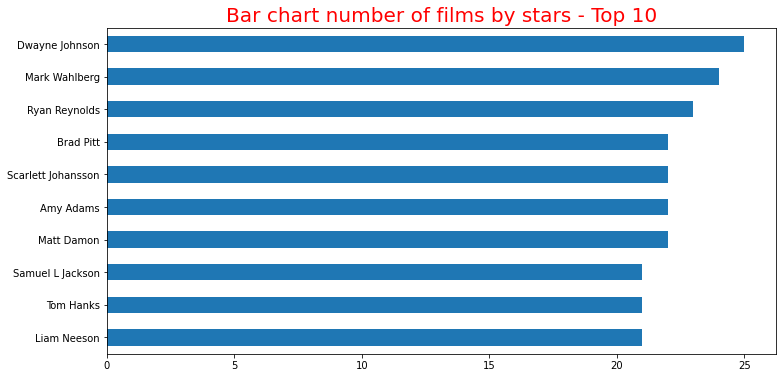

In [49]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Stars')['Stars'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by stars - Top 10', fontsize=20 ,color='red');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 diễn viên tham gia nhiều phim nhất thì nổi bật hơn là các diễn viên **Dwayne Johnson, Mark Wahlberg, Ryan Reynolds**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các diễn viên còn lại trong danh sách có số lượng chênh lệch quá đáng kể so với các diễn viên trên.</span>

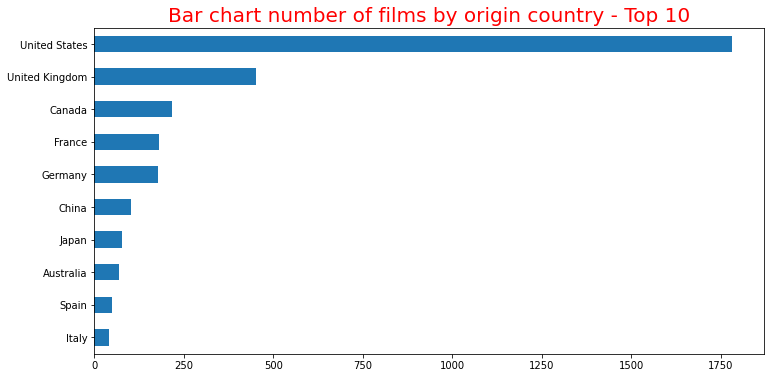

In [69]:
plt.rcParams['figure.figsize'] = 12,6
movie_df.explode('Country_of_origin')['Country_of_origin'].value_counts(ascending=True).tail(10).plot.barh()
plt.title('Bar chart number of films by origin country - Top 10', fontsize=20 ,color='red');

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Trong 10 quốc gia tham gia sản xuất phim thì **USA** lại chiếm số lượng áp đảo. Tiếp theo vẫn là các quốc gia **Canada, UK, France, Germany**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Các quốc gia còn lại thì số lương chênh nhau không đáng kể nhưng khá thấp so với các quốc gia ở trên.</span>

### 3.7 Phân tích mối quan hệ giữa các biến

<span style="font-size:18px;font-family: Times New Roman;">**Mối quan hệ giữa Runtime, Budget và Income** </span> 

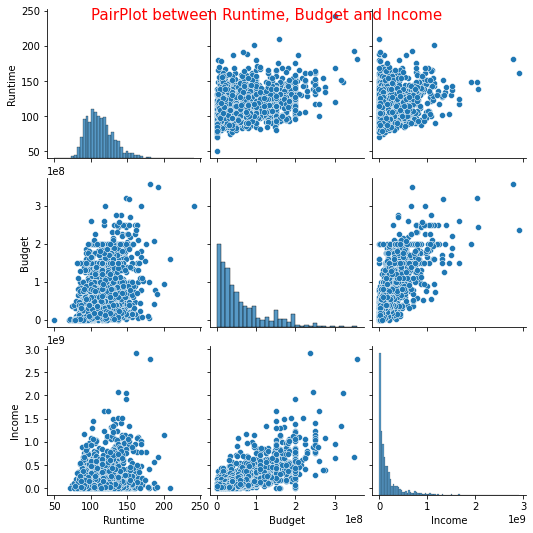

In [84]:
plt.rcParams['figure.figsize'] = 15,8
data = movie_df[['Runtime','Budget','Income']]
sns.pairplot(data)
plt.suptitle('PairPlot between Runtime, Budget and Income',fontsize = 15, color = 'red')
plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dựa vào pairplot thì thấy rõ giữa **Income** và **Budget** có quan hệ tuyến tính.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Với **Runtime** thì có quan hệ tuyến tính với **Income** và **Budget** nhưng khá yếu và điểm giá trị nó tập trung tại một vùng chứ không tuyến tính như **Income** với **Budget**</span>

<span style="font-size:18px;font-family: Times New Roman;">**Mối quan hệ giữa Runtime, Bugdet với Rating** </span> 

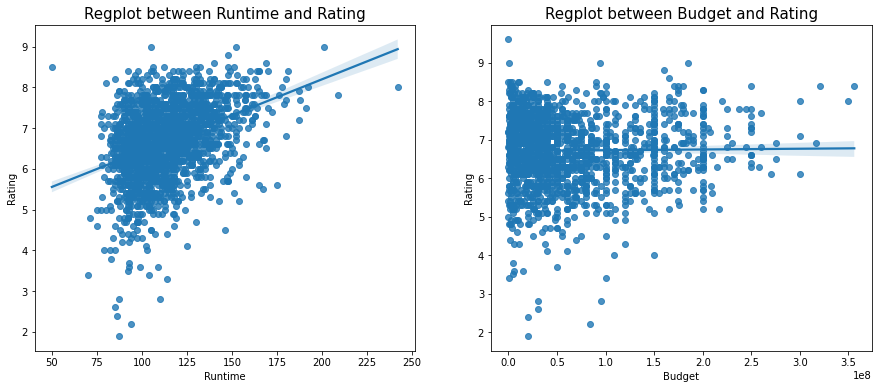

In [95]:
fig, axs = plt.subplots(1,2,figsize= (15,6))
sns.regplot(x = 'Runtime', y = 'Rating', data = movie_df, ax = axs[0]);
axs[0].set_title('Regplot between Runtime and Rating', fontsize = 15)

sns.regplot(x = 'Budget', y = 'Rating', data = movie_df, ax = axs[1]);
axs[1].set_title('Regplot between Budget and Rating', fontsize = 15)

plt.show();

<span style="font-size:18px;font-family: Times New Roman;">**Nhận xét** </span>
- <span style="font-size:17px;font-family: Times New Roman;">Dựa vào regplot thì thấy rõ quan hệ tuyế tính giữa **Runtime** và **Rating**.</span>
- <span style="font-size:17px;font-family: Times New Roman;">Giữa **Budget** và **Rating** thì ta thấy đường linear gần như đi ngang. Chứng tỏ 2 biến này gần như không có quan hệ tuyến tính và điểm giá trị tập trung</span>